In [1]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (26, 9)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM, hart_85, MLE
from nilmtk.metrics import f1_score#, precision_recall
#from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, accuracy_score

In [2]:
train = DataSet('filtered.h5')
test = DataSet('filtered.h5')

In [3]:
building = 1

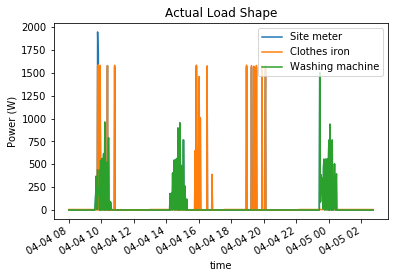

In [4]:
train.set_window(end="2018-04-04 08:00:00")
test.set_window(start="2018-04-04 08:00:00")
train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

test_elec.plot()
plt.xlabel('time');
plt.title("Actual Load Shape");

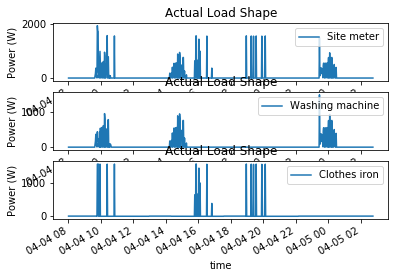

In [5]:
plt.subplot(311)
test_elec.mains().plot()
plt.xlabel('time')
plt.title("Actual Load Shape")
plt.subplot(312)
test_elec.select_using_appliances(type=['washing machine']).plot()
plt.xlabel('time');
plt.title("Actual Load Shape");
plt.subplot(313)
test_elec.select_using_appliances(type=['clothes iron']).plot()
plt.xlabel('time');
plt.title("Actual Load Shape");

In [6]:
start = time.time()
fhmm = FHMM()
fhmm.train(train_elec, sample_period=1)
end = time.time()
print("Runtime =", end-start, "seconds.")

start = time.time()
co = CombinatorialOptimisation()
co.train(train_elec, sample_period=1)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=9, building=1, dataset='ALD', appliances=[Appliance(type='clothes iron', instance=1)])'
Training model for submeter 'ElecMeter(instance=13, building=1, dataset='ALD', appliances=[Appliance(type='washing machine', instance=1)])'
Runtime = 8.687000036239624 seconds.
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='ALD', appliances=[Appliance(type='clothes iron', instance=1)])'
Training model for submeter 'ElecMeter(instance=13, building=1, dataset='ALD', appliances=[Appliance(type='washing machine', instance=1)])'
Done training!
Runtime = 5.080999851226807 seconds.


In [7]:
fhmm_filename = 'fhmmfiltered.h5'
output = HDFDataStore(fhmm_filename, 'w')
fhmm.disaggregate(test_elec.mains(), output, sample_period=1)
output.close()

co_filename = 'cofiltered.h5'
output = HDFDataStore(co_filename, 'w')
co.disaggregate(test_elec.mains(), output, sample_period=1)
output.close()

D:\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='ALD', appliances=[Appliance(type='clothes iron', instance=1)])'
Estimating power demand for 'ElecMeter(instance=13, building=1, dataset='ALD', appliances=[Appliance(type='washing machine', instance=1)])'


In [8]:
fhmmdisag = DataSet(fhmm_filename)
fhmm_elec = fhmmdisag.buildings[building].elec
print ('FHMM f1_score:')
print (f1_score(fhmm_elec, test_elec))

codisag = DataSet(co_filename)
co_elec = codisag.buildings[building].elec
print ('CO f1_score:')
print (f1_score(co_elec, test_elec))

#pd.dataframe(next(co_elec['clothes iron']))
#precision_score(next(co_elec['clothes iron']), next(test_elec['clothes iron']), average='weighted')

#print ('%-15s%-15s%-15s%-15s' % ('filename', 'precision', 'recall', 'f1-score'))
#print ('%-15s%-15f%-15f%-15f' % (self.filename, precision_score(co_elec, test_elec, average='weighted'), recall_score(self.labels, self.states, average='weighted'), f1_score(self.labels, self.states, average='weighted')))

FHMM f1_score:
9     0.774005
13    0.803471
dtype: float64
CO f1_score:
9     0.398676
13    0.772175
dtype: float64


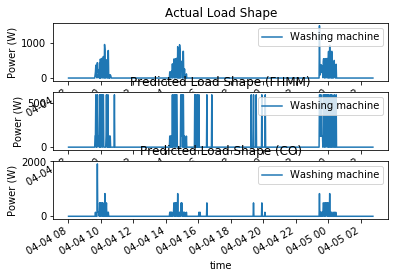

In [9]:
plt.subplot(311)
test_elec.select_using_appliances(type=['washing machine']).plot()
plt.xlabel('time')
plt.title("Actual Load Shape")
plt.subplot(312)
fhmm_elec.select_using_appliances(type=['washing machine']).plot()
plt.xlabel('time');
plt.title("Predicted Load Shape (FHMM)");
plt.subplot(313)
co_elec.select_using_appliances(type=['washing machine']).plot()
plt.xlabel('time');
plt.title("Predicted Load Shape (CO)");

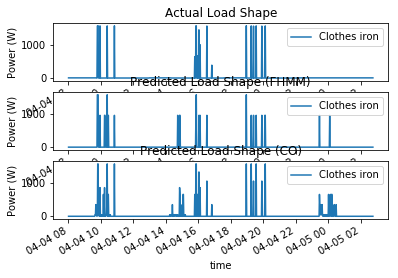

In [10]:
plt.subplot(311)
test_elec.select_using_appliances(type=['clothes iron']).plot()
plt.xlabel('time')
plt.title("Actual Load Shape")
plt.subplot(312)
fhmm_elec.select_using_appliances(type=['clothes iron']).plot()
plt.xlabel('time');
plt.title("Predicted Load Shape (FHMM)");
plt.subplot(313)
co_elec.select_using_appliances(type=['clothes iron']).plot()
plt.xlabel('time');
plt.title("Predicted Load Shape (CO)");

In [12]:
# Retrieve Features for trainings and testings
w_feats = next(fhmm_elec['washing machine'].load())
w_feats['co'] = next(co_elec['washing machine'].load())

c_feats = next(fhmm_elec['clothes iron'].load())
c_feats['co'] = next(co_elec['clothes iron'].load())

In [13]:
# Retrieve Responses for trainings and testings
tfeatures = next(test_elec['washing machine'].load())
w_class = [('Washing Machine' if x > 20 else 'Not Washing Machine') for x in tfeatures['power','active']]
tfeatures = next(test_elec['clothes iron'].load())
c_class = [('Clothes Iron' if x > 500 else 'Not Clothes Iron') for x in tfeatures['power','active']]

In [14]:
#%% Create trainset and testset for washing machine
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(w_feats, w_class)

In [15]:
#%% training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
import itertools

start = time.time()
print("Naive Bayes Training...")
gnb = GaussianNB().fit(X_train, y_train)
end = time.time()
print("Runtime =", end-start, "seconds.")
start = time.time()
print("Naive Bayes Prediction...")
y_pred = gnb.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
end = time.time()
print("Runtime =", end-start, "seconds.")

Naive Bayes Training...
Runtime = 0.05000019073486328 seconds.
Naive Bayes Prediction...
[[14714   275]
 [  588  1304]]
                     precision    recall  f1-score   support

Not Washing Machine       0.96      0.98      0.97     14989
    Washing Machine       0.83      0.69      0.75      1892

        avg / total       0.95      0.95      0.95     16881

Runtime = 0.13100004196166992 seconds.


In [16]:
#%% training a Neural Network classifier
from sklearn.neural_network import MLPClassifier
start = time.time()
print("Training Neural Network...")
mlp = MLPClassifier(activation='relu', alpha=0.00001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40, 30, 30, 30, 30, 40), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train,y_train)
end = time.time()
print("Runtime =", end-start, "seconds.")

start = time.time()
print("Neural Network Prediction...")
y_pred = mlp.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
end = time.time()
print("Runtime =", end-start, "seconds.")

Training Neural Network...
Runtime = 4.553499937057495 seconds.
Neural Network Prediction...
[[14891    98]
 [  280  1612]]
                     precision    recall  f1-score   support

Not Washing Machine       0.98      0.99      0.99     14989
    Washing Machine       0.94      0.85      0.90      1892

        avg / total       0.98      0.98      0.98     16881

Runtime = 0.17549991607666016 seconds.


In [17]:
#%% Create trainset and testset for clothes iron
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(c_feats, c_class)

In [18]:
#%% training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
import itertools

start = time.time()
print("Naive Bayes Training")
gnb = GaussianNB().fit(X_train, y_train)
end = time.time()
print("Runtime =", end-start, "seconds.")

start = time.time()
print("Naive Bayes Prediction...")
y_pred = gnb.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
end = time.time()
print("Runtime =", end-start, "seconds.")

Naive Bayes Training
Runtime = 0.04400014877319336 seconds.
Naive Bayes Prediction...
[[  429    21]
 [  209 16222]]
                  precision    recall  f1-score   support

    Clothes Iron       0.67      0.95      0.79       450
Not Clothes Iron       1.00      0.99      0.99     16431

     avg / total       0.99      0.99      0.99     16881

Runtime = 0.11899995803833008 seconds.


In [19]:
#%% training a Neural Network classifier
from sklearn.neural_network import MLPClassifier
start = time.time()
print("Training Neural Network...")
mlp = MLPClassifier(activation='relu', alpha=0.00001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 40, 40, 40, 40, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(X_train,y_train)
end = time.time()
print("Runtime =", end-start, "seconds.")

start = time.time()
print("Neural Network Prediction...")
y_pred = mlp.predict(X_test)
end = time.time()
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Runtime =", end-start, "seconds.")

Training Neural Network...
Runtime = 4.12250018119812 seconds.
Neural Network Prediction...
[[  406    44]
 [   96 16335]]
                  precision    recall  f1-score   support

    Clothes Iron       0.81      0.90      0.85       450
Not Clothes Iron       1.00      0.99      1.00     16431

     avg / total       0.99      0.99      0.99     16881

Runtime = 0.03600001335144043 seconds.
